# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [7]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

In [2]:
#LAV API HER, SÅ DEN HENTER DATA NED.

In [5]:
# Import itertools for generating parameter combinations
from itertools import product

# Define a function to calculate the Taylor rule nominal interest rate
def calculate_taylor_rate(current_inflation, target_inflation, equilibrium_real_int_rate, output_gap, a_pi=0.5, a_y=0.5):
    """
    Calculate the target nominal interest rate using the Taylor rule.

    Parameters:
    - current_inflation: The current inflation rate (π_t)
    - target_inflation: The desired inflation rate (π^*)
    - equilibrium_real_int_rate: The assumed equilibrium real interest rate (r^*_t)
    - output_gap: The difference between current output and potential output (yt - yt_bar)
    - a_pi: Weight assigned to the inflation gap (default is 0.5)
    - a_y: Weight assigned to the output gap (default is 0.5)

    Returns:
    - The target nominal interest rate (i_t)
    """
    # Calculate the inflation gap (π_t - π^*)
    inflation_gap = current_inflation - target_inflation

    # Compute the target nominal interest rate using the Taylor rule formula
    target_nominal_rate = current_inflation + equilibrium_real_int_rate + a_pi * inflation_gap + a_y * output_gap

    # Return the calculated nominal interest rate
    return target_nominal_rate

# Define a list of potential values for the parameters
current_inflation_values = [0.015, 0.02, 0.025]  # Current inflation rates (1.5%, 2%, 2.5%)
target_inflation_values = [0.02]                # Target inflation rate (2%)
equilibrium_real_int_rate_values = [0.01, 0.015]    # Equilibrium real interest rates (1%, 1.5%)
output_gap_values = [-0.01, 0, 0.01]            # Output gap values (-1%, 0%, 1%)
a_pi_values = [0.5, 0.75]                       # Weight for inflation gap (0.5, 0.75)
a_y_values = [0.5, 1]                           # Weight for output gap (0.5, 1)

# Generate all possible combinations of parameters
parameter_combinations = list(product(
    current_inflation_values, target_inflation_values, equilibrium_real_int_rate_values,
    output_gap_values, a_pi_values, a_y_values
))

# Iterate through each combination of parameters
for params in parameter_combinations:
    # Unpack the parameter values
    current_inflation, target_inflation, equilibrium_real_int_rate, output_gap, a_pi, a_y = params

    # Calculate the nominal interest rate for this combination
    taylor_rate = calculate_taylor_rate(current_inflation, target_inflation, equilibrium_real_int_rate, output_gap, a_pi, a_y)

    # Print out the combination of parameters and the resulting interest rate
    print(f"Current inflation: {current_inflation:.2%}, Target inflation: {target_inflation:.2%}, "
          f"Equilibrium rate: {equilibrium_real_int_rate:.2%}, Output gap: {output_gap:.2%}, "
          f"a_pi: {a_pi}, a_y: {a_y} => Taylor rate: {taylor_rate:.2%}")

Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: -1.00%, a_pi: 0.5, a_y: 0.5 => Taylor rate: 1.75%
Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: -1.00%, a_pi: 0.5, a_y: 1 => Taylor rate: 1.25%
Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: -1.00%, a_pi: 0.75, a_y: 0.5 => Taylor rate: 1.62%
Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: -1.00%, a_pi: 0.75, a_y: 1 => Taylor rate: 1.13%
Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: 0.00%, a_pi: 0.5, a_y: 0.5 => Taylor rate: 2.25%
Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: 0.00%, a_pi: 0.5, a_y: 1 => Taylor rate: 2.25%
Current inflation: 1.50%, Target inflation: 2.00%, Equilibrium rate: 1.00%, Output gap: 0.00%, a_pi: 0.75, a_y: 0.5 => Taylor rate: 2.12%
Current inflation: 1.50%, Target inflati

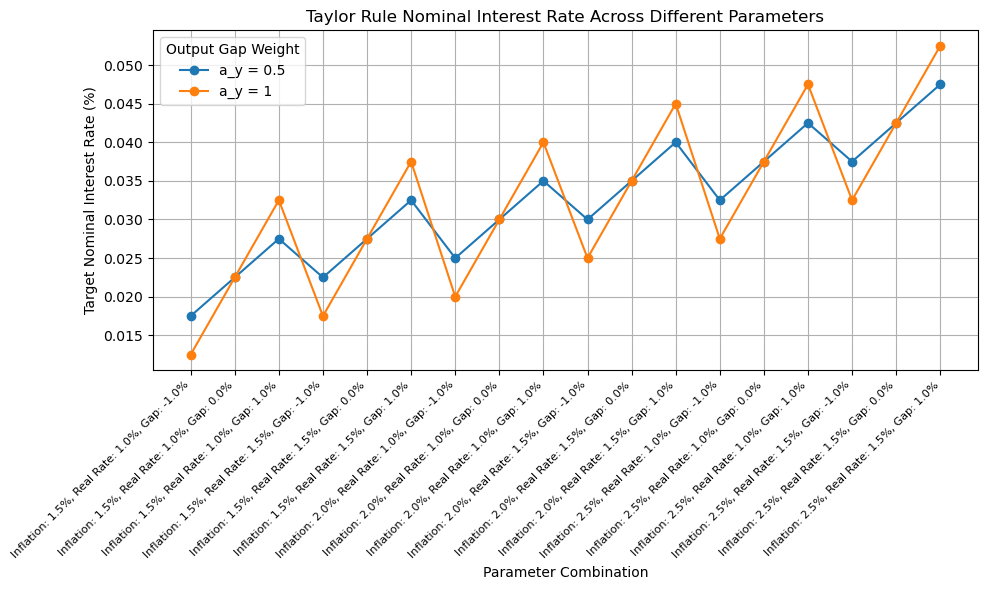

In [8]:
# Set up lists for parameter values (limited for visualization clarity)
current_inflation_values = [0.015, 0.02, 0.025]  # Current inflation rates (1.5%, 2%, 2.5%)
target_inflation = 0.02                          # Fixed target inflation rate (2%)
equilibrium_real_int_rate_values = [0.01, 0.015]     # Equilibrium real interest rates (1%, 1.5%)
output_gap_values = [-0.01, 0, 0.01]             # Output gap values (-1%, 0%, 1%)
a_pi = 0.5                                       # Fixed weight for inflation gap (0.5)
a_y_values = [0.5, 1]                            # Different weights for output gap (0.5, 1)

# Initialize a figure for plotting
plt.figure(figsize=(10, 6))

# Iterate over output gap weights (a_y) to generate separate lines
for a_y in a_y_values:
    # Store results for plotting
    results = []
    labels = []

    # Generate combinations of inflation and equilibrium rate values
    for current_inflation, equilibrium_real_int_rate, output_gap in product(
        current_inflation_values, equilibrium_real_int_rate_values, output_gap_values
    ):
        # Calculate the nominal interest rate using the Taylor rule
        taylor_rate = calculate_taylor_rate(current_inflation, target_inflation, equilibrium_real_int_rate, output_gap, a_pi, a_y)

        # Store results (with tuple for labels)
        results.append(taylor_rate)
        labels.append(f"Inflation: {current_inflation:.1%}, Real Rate: {equilibrium_real_int_rate:.1%}, Gap: {output_gap:.1%}")

    # Plot the results with varying output gap weights (a_y)
    plt.plot(range(len(results)), results, marker='o', label=f"a_y = {a_y}")

# Set plot title and labels
plt.title("Taylor Rule Nominal Interest Rate Across Different Parameters")
plt.xlabel("Parameter Combination")
plt.ylabel("Target Nominal Interest Rate (%)")
plt.xticks(range(len(results)), labels, rotation=45, ha='right', fontsize=8)
plt.legend(title="Output Gap Weight")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 